In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
import os

zip_ref = zipfile.ZipFile('/content/drive/MyDrive/BT_DL.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/tmp') #Extracts the files into the /tmp folder
zip_ref.close()

In [ ]:
len(os.listdir('/tmp/Training')), len(os.listdir('/tmp/Testing'))

(4, 4)

In [ ]:
(len(os.listdir('/tmp/Training/meningioma_tumor')),len(os.listdir('/tmp/Training/no_tumor')),len(os.listdir('/tmp/Training/glioma_tumor')),
len(os.listdir('/tmp/Training/pituitary_tumor')))


(822, 790, 826, 827)

In [ ]:
(len(os.listdir('/tmp/Testing/meningioma_tumor')),len(os.listdir('/tmp/Testing/no_tumor')),len(os.listdir('/tmp/Testing/glioma_tumor')),
len(os.listdir('/tmp/Testing/pituitary_tumor')))

(115, 105, 100, 74)

In [ ]:
import seaborn as sns
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import torch
import glob
import torch.nn as nn
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.autograd import Variable
import torchvision
import pathlib

from skimage.io import imread
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tqdm import tqdm

from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
import warnings
warnings.filterwarnings("ignore")

**CNN**

In [ ]:
transforming_img = transforms.Compose([
    transforms.Resize((150,150)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5],
                        [0.5,0.5,0.5])
])

In [ ]:
train_path = ('/tmp/Training/')
test_path = ('/tmp/Testing/')

train_loader=DataLoader(
    torchvision.datasets.ImageFolder(train_path,transform=transforming_img),
    batch_size=12, shuffle=True
)
test_loader=DataLoader(
    torchvision.datasets.ImageFolder(test_path,transform=transforming_img),
    batch_size=12, shuffle=True
)


#categories
root=pathlib.Path(train_path)
classes=sorted([j.name.split('/')[-1] for j in root.iterdir()])

In [ ]:
print(f'The classes are: {classes}')

The classes are: ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


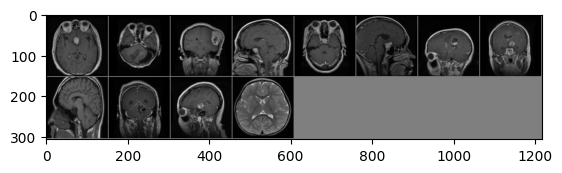

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
batch_size = 6

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # move channel dimension to the last dimension
    # plt.imshow(npimg)  # move channel dimension to the last dimension

    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)  # batch size of 6

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [ ]:
class ConvNet(nn.Module):
    def __init__(self,num_classes=4):
        super(ConvNet,self).__init__()


        self.conv1=nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3, stride=1, padding=1)
        self.bn1=nn.BatchNorm2d(num_features=12)
        self.relu1=nn.ReLU()
        self.pool=nn.MaxPool2d(kernel_size=2)
        self.conv2=nn.Conv2d(in_channels=12,out_channels=20,kernel_size=3,stride=1,padding=1)
        self.relu2=nn.ReLU()
        self.conv3=nn.Conv2d(in_channels=20,out_channels=32,kernel_size=3,stride=1,padding=1)
        self.bn3=nn.BatchNorm2d(num_features=32)
        self.relu3=nn.ReLU()
        self.fc=nn.Linear(in_features=75 * 75 * 32,out_features=num_classes)



        #Feed forwad function

    def forward(self,input):
        output=self.conv1(input)
        output=self.bn1(output)
        output=self.relu1(output)
        output=self.pool(output)
        output=self.conv2(output)
        output=self.relu2(output)
        output=self.conv3(output)
        output=self.bn3(output)
        output=self.relu3(output)
        output=output.view(-1,32*75*75)
        output=self.fc(output)

        return output

device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model=ConvNet(num_classes=4).to(device)

pituitary_tumor glioma_tumor meningioma_tumor pituitary_tumor pituitary_tumor meningioma_tumor


In [ ]:
for i, (images,labels) in enumerate(train_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())

In [ ]:
images.shape

torch.Size([1, 3, 150, 150])

In [ ]:
import torch.optim as optim

# CrossEntropyLoss for multi-class classification
criterion = nn.CrossEntropyLoss()
# Select SGD as the optimizer here. There are also other optimizers, such as Adam, RMSprop.
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
print(torch.cuda.is_available()) # where cuda can be used
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') # set the device

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

True
cuda:0


In [ ]:
net = model.to(device) # transfer network to device
max_epochs = 18  # specify the maximum number of training epoches
net.train()
for epoch in range(max_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # transfer data to device
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()  # compute the gradient
        optimizer.step()  # apply the gradient

        # print statistics
        running_loss += loss.item()
        if i % 240 == 239:
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss*10:.3f}')
            running_loss = 0.0


print('Finished Training')

[1,   240] loss: 9333.822
[2,   240] loss: 1386.826
[3,   240] loss: 1004.851
[4,   240] loss: 785.407
[5,   240] loss: 682.548
[6,   240] loss: 553.983
[7,   240] loss: 418.068
[8,   240] loss: 471.761
[9,   240] loss: 317.426
[10,   240] loss: 262.111
[11,   240] loss: 220.789
[12,   240] loss: 187.094
[13,   240] loss: 178.327
[14,   240] loss: 120.430
[15,   240] loss: 151.633
[16,   240] loss: 240.057
[17,   240] loss: 126.674
[18,   240] loss: 82.882
Finished Training


In [ ]:
PATH = '/content/drive/MyDrive/Colab Notebooks/BT.pth'
torch.save(model.state_dict(), PATH)

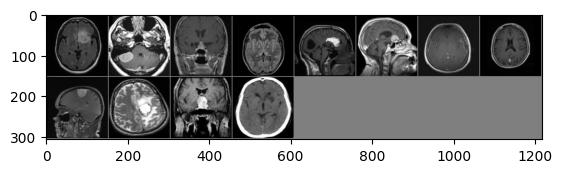

GroundTruth:  glioma_tumor meningioma_tumor pituitary_tumor no_tumor


In [ ]:
# print the sampled image
dataiter = iter(test_loader)
images, labels = next(dataiter)  # batch size of 4
# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [ ]:
# load the trained model
net = ConvNet()
net.load_state_dict(torch.load(PATH))
net = net.to(device)

In [ ]:
# get output of the image samples
outputs = net(images.to(device))
# get the predicted labels of these image samples
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  no_tumor meningioma_tumor pituitary_tumor no_tumor


In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
net.eval()
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct // total} %')

Accuracy of the network on the test images: 72 %


**ALEXNET**

In [ ]:
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

train_path2 = ('/tmp/Training/')
test_path2 = ('/tmp/Testing/')

#creating a dinstinct transform class for the train, validation and test dataset
tranform_train = transforms.Compose([transforms.Resize((227,227)), transforms.RandomHorizontalFlip(p=0.7), transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
tranform_test = transforms.Compose([transforms.Resize((227,227)), transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

#preparing the train, validation and test dataset
torch.manual_seed(43)
train_ds = DataLoader(
    torchvision.datasets.ImageFolder(train_path2,transform=tranform_train),
    batch_size=9, shuffle=True
)
val_size = 30
train_size = len(train_ds) - val_size
train_ds, val_ds = random_split(train_ds, [train_size, val_size])
test_ds = DataLoader(
    torchvision.datasets.ImageFolder(test_path2,transform=tranform_test),
    batch_size=9, shuffle=True
)

In [ ]:
#passing the train, val and test datasets to the dataloader
train_dl = DataLoader(train_ds, batch_size=3, shuffle=True,num_workers=1)
val_dl = DataLoader(val_ds, batch_size=3, shuffle=False,num_workers=1)
test_dl = DataLoader(test_ds, batch_size=3, shuffle=False,num_workers=1)

In [ ]:
len(train_dl),len(val_dl),len(test_dl),len(train_ds)

(111, 10, 15, 333)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
class AlexNet(nn.Module):
    def __init__(self,num_classes=4):
        super(AlexNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels= 96, kernel_size= 11, stride=4, padding=0 )
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2)
        self.conv2 = nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, stride= 1, padding= 2)
        self.conv3 = nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, stride= 1, padding= 1)
        self.conv4 = nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.fc1  = nn.Linear(in_features= 9216, out_features= 4096)
        self.fc2  = nn.Linear(in_features= 4096, out_features= 4096)
        self.fc3 = nn.Linear(in_features=4096 , out_features=10)


    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = self.maxpool(x)
        x = F.relu(self.conv2(x))
        x = self.maxpool(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = self.maxpool(x)
        x = x.reshape(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

alex_net=AlexNet(num_classes=4).to(device)

In [ ]:
len(train_dl),len(train_ds)

(111, 333)

In [ ]:
import torch.optim as optim

In [ ]:
#alex_net = AlexNet() #to compile the model
#alex_net = alex_net.to(device=device) #to send the model for training on either cuda or cpu

## Loss and optimizer
learning_rate = 1e-4
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(alex_net.parameters(), lr= learning_rate)

In [ ]:
max_epochs = 1  # specify the maximum number of training epoches Here we only train 2 epoches
alex_net.train()
for epoch in range(max_epochs):
    loss_ep = 0

    for batch_idx, (data, targets) in enumerate(train_dl):
      data = data.to(device=device)
      targets = targets.to(device=device)
      ## Forward Pass
      optimizer.zero_grad()
      scores = alex_net(data)
      loss = criterion(scores,targets)
      loss.backward()
      optimizer.step()
      loss_ep += loss.item()
      print(f"Loss in epoch {epoch} :::: {loss_ep/len(train_dl)}")

    with torch.no_grad():
        num_correct = 0
        num_samples = 0
        for batch_idx, (data,targets) in enumerate(val_ds.dataset):
            data = data.to(device=device)
            targets = targets.to(device=device)
            ## Forward Pass
            scores = alex_net(data)
            _, predictions = scores.max(1)
            num_correct += (predictions == targets).sum()
            num_samples += predictions.size(0)
        print(
            f"Got {num_correct} / {num_samples} with accuracy {float(num_correct) / float(num_samples) * 100:.2f}"
        )


print('Finished Training')

TypeError: ignored

In [ ]:
num_correct = 0
num_samples = 0
alex_net.eval()
for batch_idx, (data,targets) in enumerate(test_ds):
    data = data.to(device=device)
    targets = targets.to(device=device)
    ## Forward Pass
    scores = alex_net(data)
    _, predictions = scores.max(1)
    num_correct += (predictions == targets).sum()
    num_samples += predictions.size(0)
print(
    f"Got {num_correct} / {num_samples} with accuracy {float(num_correct) / float(num_samples) * 100:.2f}"
)